In [240]:
# Standard import(s)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [241]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

In [242]:
def load_dataset():
    #
    num_snaps = 20000
    tdiff = 9.0
    grid_dataset_list = []
    file_index = 1
    alphas = np.linspace(0.2, 0.8, 4)
    betas = np.linspace(0.2, 0.8, 4)
    
    for alpha in alphas:
        for beta in betas:
            if alpha + beta == 1:
                pair = (round(alpha, 2), round(beta, 2))
                grid_pt_data = pd.read_csv("RealTimeSnaps{}alpha{}beta{}tdiff{}.csv".format(num_snaps, pair[0], pair[1], tdiff), header=None)
                grid_pt_data['y'] = [file_index] * grid_pt_data.shape[0]
                grid_dataset_list.append(grid_pt_data)
                print('Alpha, Beta is {} and given label {}'.format(pair, file_index))
                file_index += 1
    
    grid_dataset = pd.concat(grid_dataset_list)

    X = grid_dataset.iloc[:, :-1]
    y = grid_dataset.iloc[:, -1]
    
    return X, y, file_index

In [243]:
X, y, file_index = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
print(X_train.shape)

Alpha, Beta is (0.2, 0.8) and given label 1
Alpha, Beta is (0.4, 0.6) and given label 2
Alpha, Beta is (0.6, 0.4) and given label 3
Alpha, Beta is (0.8, 0.2) and given label 4
(40000, 100)


In [244]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [245]:
original_dim = 100
intermediate_dim = 75
intermediate_dim2 = 50
intermediate_dim3 = 25
latent_dim = 2

In [246]:
inputs = Input(original_dim, name='input')

x = Dense(intermediate_dim, activation='relu')(inputs)

# Means and log(variances) layers both connected to previous dense layer
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [247]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 75)           7575        input[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            152         dense_35[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            152         dense_35[0][0]                   
____________________________________________________________________________________________

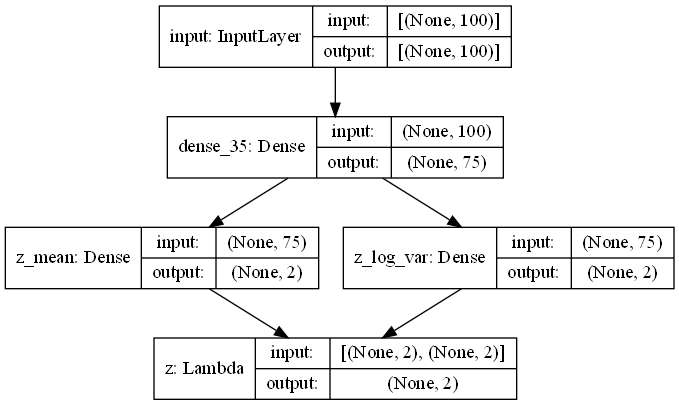

In [248]:
plot_model(encoder, show_shapes=True)

In [249]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

In [250]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 75)                225       
_________________________________________________________________
dense_37 (Dense)             (None, 100)               7600      
Total params: 7,825
Trainable params: 7,825
Non-trainable params: 0
_________________________________________________________________


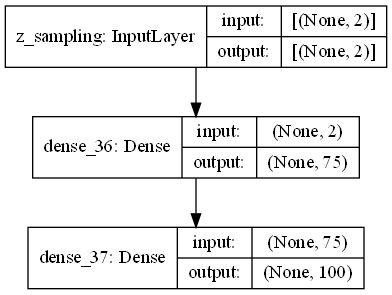

In [251]:
plot_model(decoder, show_shapes=True)

In [252]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [253]:
vae = Model(i, o, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 7879      
_________________________________________________________________
decoder (Model)              (None, 100)               7825      
Total params: 15,704
Trainable params: 15,704
Non-trainable params: 0
_________________________________________________________________


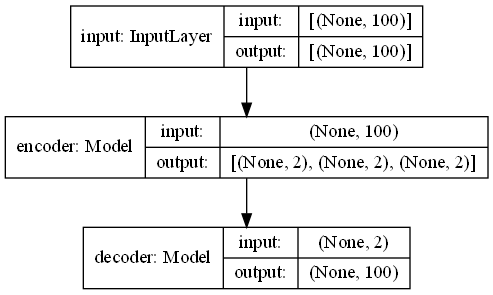

In [254]:
plot_model(vae, show_shapes=True)

In [255]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [256]:
# Define parameters
nb_epochs  =  10
batch_size = 100

In [257]:
# Compile with given compile function to include custom VAE loss function
compile_vae(vae)

vae_history = vae.fit(X_train, X_train,
                      epochs=nb_epochs,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 1s 46us/sample - loss: 63.5376 - reco_loss: 62.2583 - kl_loss: 1.2794 - val_loss: 60.7637 - val_reco_loss: 59.2323 - val_kl_loss: 1.5315
Epoch 2/10
32000/32000 [==============================] - 1s 31us/sample - loss: 60.4377 - reco_loss: 58.8489 - kl_loss: 1.5888 - val_loss: 60.5160 - val_reco_loss: 58.9477 - val_kl_loss: 1.5684
Epoch 3/10
32000/32000 [==============================] - 1s 31us/sample - loss: 60.2731 - reco_loss: 58.6972 - kl_loss: 1.5758 - val_loss: 60.4163 - val_reco_loss: 58.8504 - val_kl_loss: 1.5659
Epoch 4/10
32000/32000 [==============================] - 1s 32us/sample - loss: 60.2171 - reco_loss: 58.6383 - kl_loss: 1.5787 - val_loss: 60.3709 - val_reco_loss: 58.8442 - val_kl_loss: 1.5267
Epoch 5/10
32000/32000 [==============================] - 1s 32us/sample - loss: 60.1951 - reco_loss: 58.6174 - kl_loss: 1.5776 - val_loss: 60.3367 - val_reco_loss: 58.817

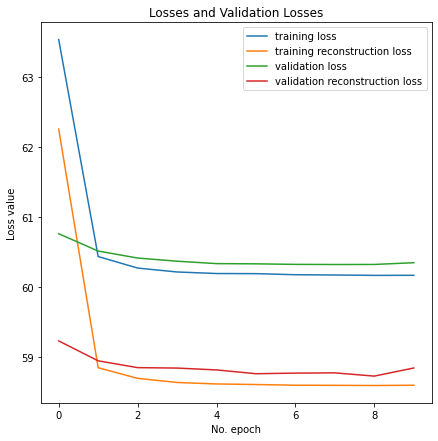

In [258]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
#plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
#plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

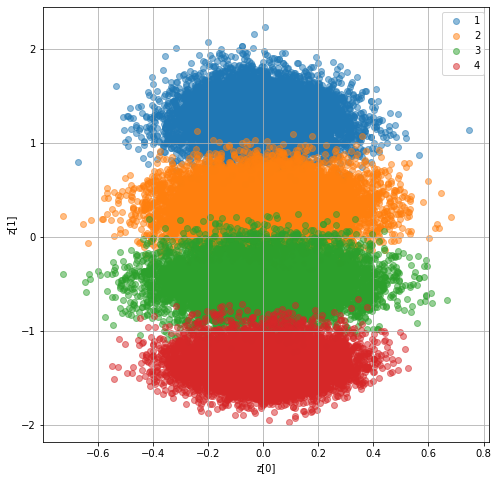

In [259]:
# Encoder outputs mean, log(var) and a sample z from pdf so took mean just for plotting but could alternatively
# plot sampled z
z_mean, _, _ = encoder.predict(X_test)

# Create figure and axis objects.
fig, ax = plt.subplots(figsize=(8,8))
# Loop for each digit label
for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current digit on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               single_label[:, 1],
               label=t, alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space for next part clear
ax.grid()
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

In [260]:
single_label[:, 0]

array([ 0.1410948 ,  0.08542844, -0.11794315, ..., -0.2881362 ,
       -0.15773204,  0.00154686], dtype=float32)

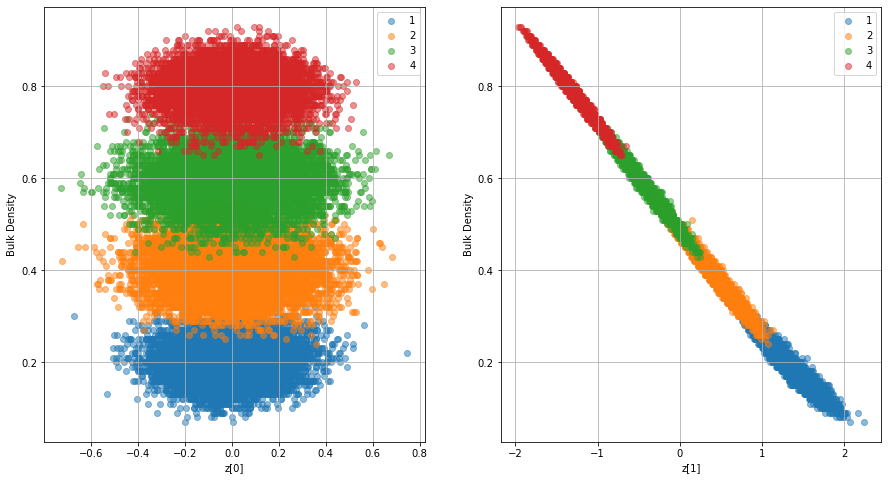

In [261]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].scatter(single_label[:, 0],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    ax[1].scatter(single_label[:, 1],
               np.mean(X_test[mask], axis=1),
               label=t, alpha=0.5)
    pass

# Draw legend
ax[0].legend()
# Include grid lines to make chosen region of latent space clear
ax[0].grid()
ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Bulk Density')
# Draw legend
ax[1].legend()
# Include grid lines to make chosen region of latent space clear
ax[1].grid()
ax[1].set_xlabel('z[1]')
ax[1].set_ylabel('Bulk Density')

plt.show()

In [262]:
X_test_currents = []
for i in range(len(X_test)):
    jumps_possible = 0
    occs = np.array(X_test.iloc[i])
    for j in range(len(occs)): 
        if  j == len(occs)-1 and occs[j] == 1:
            jumps_possible += 1
        elif occs[j] == 1 and occs[j+1] == 0:
            jumps_possible += 1
    X_test_currents.append(jumps_possible / len(occs))
    
X_test_currents = np.array(X_test_currents)

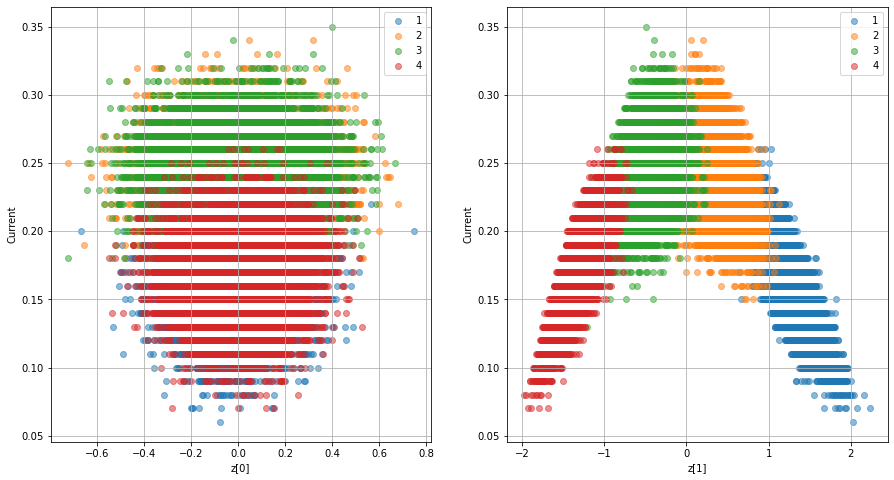

In [263]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].scatter(single_label[:, 0],
               X_test_currents[mask],
               label=t, alpha=0.5)
    ax[1].scatter(single_label[:, 1],
               X_test_currents[mask],
               label=t, alpha=0.5)
    pass

# Draw legend
ax[0].legend()
# Include grid lines to make chosen region of latent space clear
ax[0].grid()
ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Current')
# Draw legend
ax[1].legend()
# Include grid lines to make chosen region of latent space clear
ax[1].grid()
ax[1].set_xlabel('z[1]')
ax[1].set_ylabel('Current')

plt.show()

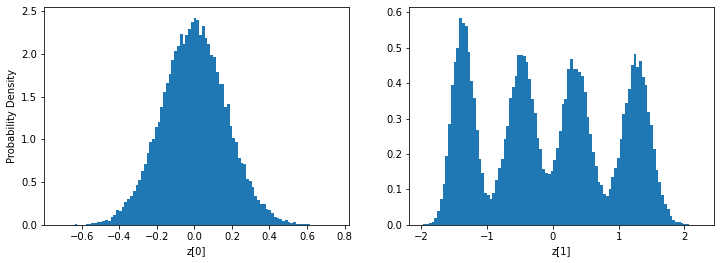

In [264]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
# Make histogram at the 
ax[0].hist(z_mean[:, 0],bins=100, density=True)
ax[1].hist(z_mean[:, 1],bins=100, density=True)

ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Probability Density')
ax[1].set_xlabel('z[1]')

plt.show()

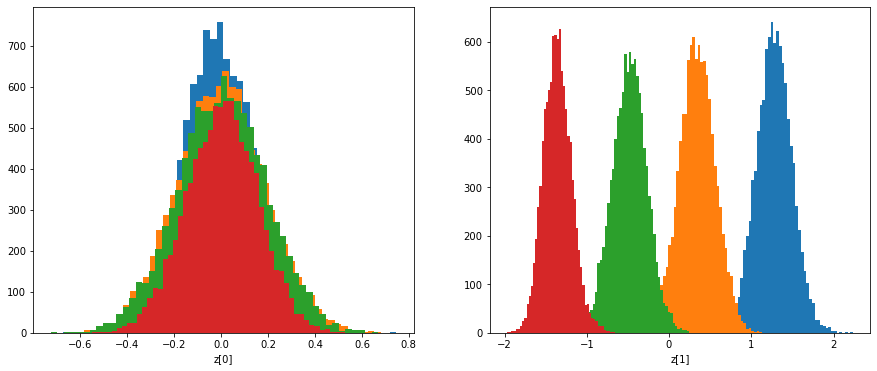

In [265]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

for t in range(1, file_index):
    # Boolean mask
    mask = y_test == t
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].hist(single_label[:, 0],
               bins=50)
    ax[1].hist(single_label[:, 1],
               bins=50)
    pass

ax[0].set_xlabel('z[0]')
ax[1].set_xlabel('z[1]')

plt.show()

In [266]:
# Size of box in latent space
z0_start = -1.75
z0_stop = -1.25
z1_start = -0.5
z1_stop = 0.5
# How many points per dimension
num_pts = 100
z0_pts_line = np.linspace(z0_start, z0_stop, num_pts)
z1_pts_line = np.linspace(z1_start, z1_stop, num_pts)
z0s, z1s = np.meshgrid(z0_pts_line, z1_pts_line)
z0s = z0s.flatten()
z1s = z1s.flatten()
zs = np.empty([num_pts**2, 2])
# Pair up the x and y points to give list of grid coordinates
for i in range(len(z1s)):
    zs[i] = z0s[i], z1s[i]

In [267]:
x_decoded = decoder.predict(np.array([zs[0]]))

In [268]:
x_decoded

array([[0.6216072 , 0.632692  , 0.6092272 , 0.58388805, 0.5949333 ,
        0.6012586 , 0.65545344, 0.62118214, 0.63238585, 0.63238215,
        0.5817162 , 0.6377095 , 0.56231534, 0.6291719 , 0.61110985,
        0.6443423 , 0.64726055, 0.64878523, 0.64187574, 0.6246051 ,
        0.6301013 , 0.6149445 , 0.65788466, 0.6088546 , 0.6285733 ,
        0.6152757 , 0.61379755, 0.56663215, 0.62975466, 0.6421837 ,
        0.64356244, 0.62489897, 0.6294886 , 0.63008803, 0.6312371 ,
        0.6307587 , 0.59169406, 0.5922637 , 0.6048182 , 0.63727885,
        0.63078547, 0.6112997 , 0.6064371 , 0.62455684, 0.6183361 ,
        0.6226434 , 0.6045239 , 0.63039213, 0.63294125, 0.6124988 ,
        0.61914694, 0.6080693 , 0.6077881 , 0.62718284, 0.6340413 ,
        0.5956741 , 0.62629   , 0.67344356, 0.6047915 , 0.61902195,
        0.6246986 , 0.6442564 , 0.6041186 , 0.6249881 , 0.58614916,
        0.6463262 , 0.60902095, 0.60967183, 0.60954875, 0.632457  ,
        0.5925353 , 0.6144522 , 0.60978335, 0.62